In [ ]:
# Importing the required libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converting the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing to range [-1, 1]
])

# CIFAR 10 training dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',          # A Directory to store the dataset
    train=True,
    download=True,
    transform=transform     # Here applying the transformations
)

# CIFAR 10 testing dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# batch size
batch_size = 64

# DataLoader for training dataset
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,           # Improving the training by shuffling
    num_workers=2           # 2 workers for faster loading
)

# DataLoader for testing dataset
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,          # No need to shuffle test data
    num_workers=2
)

# Verifying by printing dataset sizes and sample batch
print(f"Training dataset size: {len(train_dataset)} images")
print(f"Testing dataset size: {len(test_dataset)} images")

# Getting a sample batch from the training loader
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Sample batch shape: {images.shape}")
print(f"Sample labels shape: {labels.shape}")

# class names for CIFAR 10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Sample labels (first 5): {[classes[labels[i]] for i in range(5)]}")

Training dataset size: 50000 images
Testing dataset size: 10000 images
Sample batch shape: torch.Size([64, 3, 32, 32])
Sample labels shape: torch.Size([64])
Sample labels (first 5): ['frog', 'bird', 'deer', 'deer', 'ship']


In [ ]:
# Importing the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Task 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Task 2 - Defining the neural architecture

# Intermediate Block
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(IntermediateBlock, self).__init__()
        self.num_convs = num_convs
        self.in_channels = in_channels

        # Creatingg the L independent convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)  # Padding when equaled to 1 it keeps 32x3
            for _ in range(num_convs)
        ])

        # Fully connected layer to compute weights
        self.fc = nn.Linear(in_channels, num_convs)

    def forward(self, x):
        m = x.mean(dim=(2, 3))  # Shape: [batch_size, in_channels]

        # Computing weights a
        a = self.fc(m)  # Shape: [batch_size, num_convs]
        a = F.softmax(a, dim=1)

        # Applying each convolutional layer
        conv_outputs = [conv(x) for conv in self.convs]

        # Weighted sum of conv outputs
        x_prime = torch.zeros_like(conv_outputs[0])  # initializing the output tensor
        for i in range(self.num_convs):
            x_prime += a[:, i].view(-1, 1, 1, 1) * conv_outputs[i]

        return x_prime

# Output Block
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super(OutputBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, 128)  # First FC layer
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # channel wise average
        m = x.mean(dim=(2, 3))

        # Fully connected layers
        o = F.relu(self.fc1(m))
        o = self.fc2(o)
        return o

# Full Network
class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        # sequence of intermediate blocks
        self.block1 = IntermediateBlock(in_channels=3, out_channels=16, num_convs=2)
        self.block2 = IntermediateBlock(in_channels=16, out_channels=32, num_convs=3)
        self.output_block = OutputBlock(in_channels=32)

    def forward(self, x):
        x = self.block1(x)  # [batch_size, 16, 32, 32]
        x = self.block2(x)  # [batch_size, 32, 32, 32]
        o = self.output_block(x)  # [batch_size, 10]
        return o

# instantiaing the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10Classifier().to(device)

# Testing the  the model with a sample batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
print(f"Input shape: {images.shape}")
print(f"Output shape: {outputs.shape}")

Input shape: torch.Size([64, 3, 32, 32])
Output shape: torch.Size([64, 10])


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10:
  Train Loss: 2.0470, Train Accuracy: 23.41%
  Test Accuracy: 26.29%
Epoch 2/10:
  Train Loss: 1.9821, Train Accuracy: 26.36%
  Test Accuracy: 28.12%
Epoch 3/10:
  Train Loss: 1.9628, Train Accuracy: 27.53%
  Test Accuracy: 28.68%
Epoch 4/10:
  Train Loss: 1.9458, Train Accuracy: 28.53%
  Test Accuracy: 29.43%
Epoch 5/10:
  Train Loss: 1.9247, Train Accuracy: 29.28%
  Test Accuracy: 30.73%
Epoch 6/10:
  Train Loss: 1.9096, Train Accuracy: 30.32%
  Test Accuracy: 31.21%
Epoch 7/10:
  Train Loss: 1.8998, Train Accuracy: 30.57%
  Test Accuracy: 31.72%
Epoch 8/10:
  Train Loss: 1.8910, Train Accuracy: 31.11%
  Test Accuracy: 31.96%
Epoch 9/10:
  Train Loss: 1.8814, Train Accuracy: 31.70%
  Test Accuracy: 32.24%
Epoch 10/10:
  Train Loss: 1.8752, Train Accuracy: 31.73%
  Test Accuracy: 32.29%


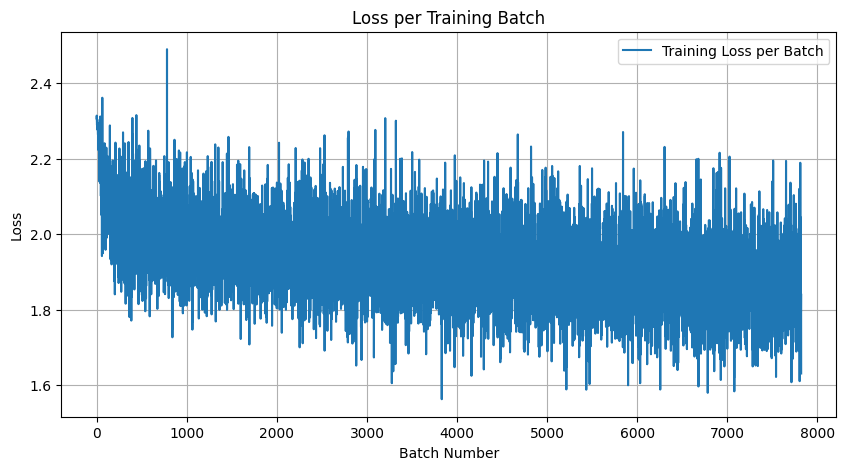

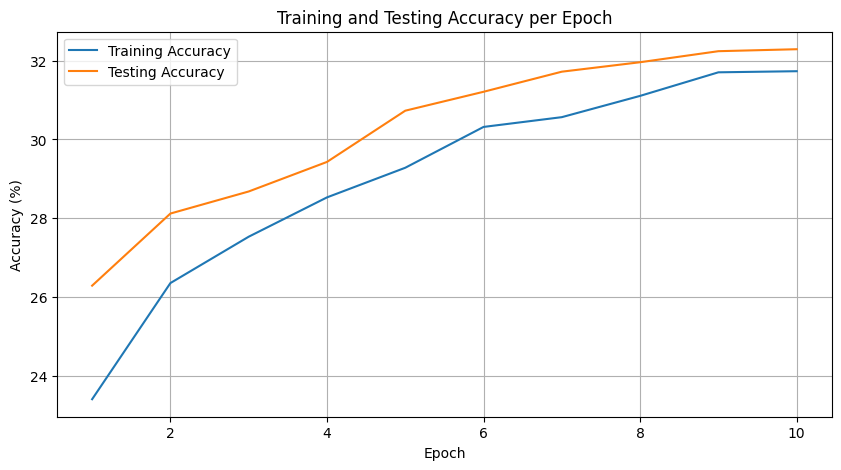

Final Test Accuracy: 32.29%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Task 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# The neural network architecture
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(IntermediateBlock, self).__init__()
        self.num_convs = num_convs
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            for _ in range(num_convs)
        ])
        self.fc = nn.Linear(in_channels, num_convs)

    def forward(self, x):
        m = x.mean(dim=(2, 3))
        a = self.fc(m)
        a = F.softmax(a, dim=1)
        conv_outputs = [conv(x) for conv in self.convs]
        x_prime = torch.zeros_like(conv_outputs[0])
        for i in range(self.num_convs):
            x_prime += a[:, i].view(-1, 1, 1, 1) * conv_outputs[i]
        return x_prime

class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super(OutputBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        m = x.mean(dim=(2, 3))
        o = F.relu(self.fc1(m))
        o = self.fc2(o)
        return o

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.block1 = IntermediateBlock(in_channels=3, out_channels=16, num_convs=2)
        self.block2 = IntermediateBlock(in_channels=16, out_channels=32, num_convs=3)
        self.output_block = OutputBlock(in_channels=32)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        o = self.output_block(x)
        return o

# Training and Testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10Classifier().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation functions
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    batch_losses = []
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_losses.append(loss.item())

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, batch_losses

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []
all_batch_losses = []

for epoch in range(num_epochs):
    train_loss, train_acc, batch_losses = train_epoch(model, train_loader, criterion, optimizer)
    test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    all_batch_losses.extend(batch_losses)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"  Test Accuracy: {test_acc:.2f}%")

# Plot 1
plt.figure(figsize=(10, 5))
plt.plot(all_batch_losses, label='Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Loss per Training Batch')
plt.legend()
plt.grid(True)
plt.show()
#plot 2
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Final test accuracy
final_test_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100:
  Train Loss: 1.9021, Train Accuracy: 34.58%
  Test Accuracy: 45.28%
Epoch 2/100:
  Train Loss: 1.6178, Train Accuracy: 48.48%
  Test Accuracy: 53.44%
Epoch 3/100:
  Train Loss: 1.4751, Train Accuracy: 56.19%
  Test Accuracy: 54.80%
Epoch 4/100:
  Train Loss: 1.3731, Train Accuracy: 61.40%
  Test Accuracy: 62.99%
Epoch 5/100:
  Train Loss: 1.3006, Train Accuracy: 65.17%
  Test Accuracy: 69.27%
Epoch 6/100:
  Train Loss: 1.2484, Train Accuracy: 67.68%
  Test Accuracy: 69.28%
Epoch 7/100:
  Train Loss: 1.2067, Train Accuracy: 69.77%
  Test Accuracy: 66.18%
Epoch 8/100:
  Train Loss: 1.1746, Train Accuracy: 71.34%
  Test Accuracy: 66.32%
Epoch 9/100:
  Train Loss: 1.1518, Train Accuracy: 72.62%
  Test Accuracy: 68.40%
Epoch 10/100:
  Train Loss: 1.1259, Train Accuracy: 73.94%
  Test Accuracy: 71.56%
Epoch 11/100:
  Train Loss: 1.1097, Train Accuracy: 74.72%
  Test Accuracy: 70.48%
Epoch 12/100:
  Trai

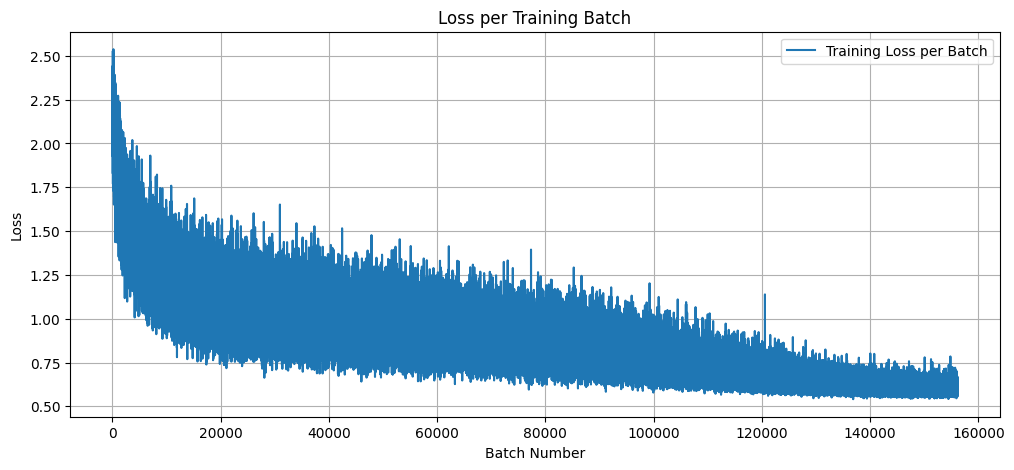

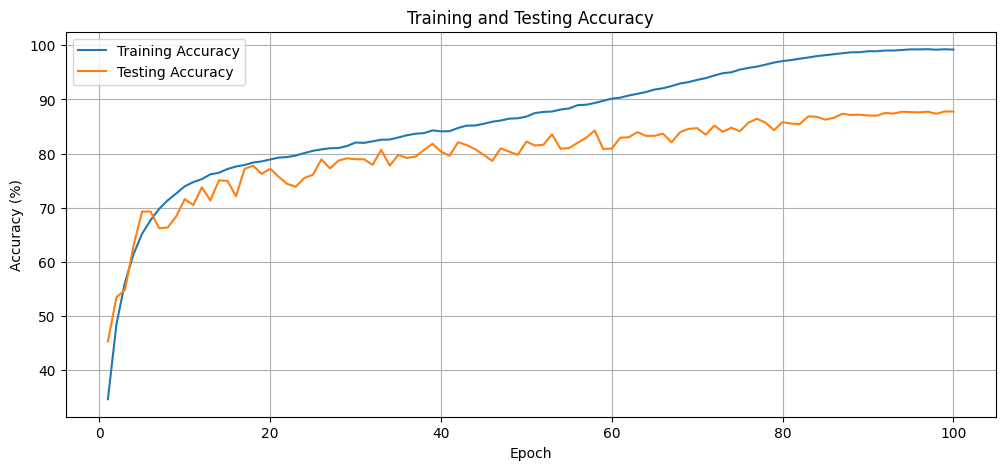

Final Test Accuracy: 87.75%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# DataLoader with reduced batch size and efficient augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

batch_size = 32  # reduced from 128 to reduce memory usage
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Intermediate Block
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(IntermediateBlock, self).__init__()
        self.num_convs = num_convs
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for _ in range(num_convs)
        ])
        self.fc = nn.Linear(in_channels, num_convs)
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) if in_channels != out_channels else None

    def forward(self, x):
        m = x.mean(dim=(2, 3))
        a = F.softmax(self.fc(m), dim=1)
        conv_outputs = [conv(x) for conv in self.convs]
        x_prime = sum(a[:, i].view(-1, 1, 1, 1) * conv_outputs[i] for i in range(self.num_convs))
        residual = self.proj(x) if self.proj is not None else x
        return F.relu(x_prime + residual)

# Output Block
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super(OutputBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, 256)  # reduced from 512
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        m = x.mean(dim=(2, 3))
        o = F.relu(self.bn1(self.fc1(m)))
        o = self.dropout(o)
        return self.fc2(o)

# Network
class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.block1 = IntermediateBlock(3, 64, num_convs=3)    # channels and blocks
        self.block2 = IntermediateBlock(64, 128, num_convs=3)
        self.block3 = IntermediateBlock(128, 256, num_convs=3)
        self.output_block = OutputBlock(256)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.output_block(x)

# Training setup with memory efficiency
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10Classifier().to(device)

# Clearing GPU memory before starting
torch.cuda.empty_cache()

# Optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)  # Reduced LR
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Training and evaluation functions with gradient accumulation
def train_epoch(model, loader, criterion, optimizer, accum_steps=4):
    model.train()
    running_loss = 0.0
    batch_losses = []
    correct = 0
    total = 0
    optimizer.zero_grad()

    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels) / accum_steps  # Normalizing loss for accumulation
        loss.backward()

        if (i + 1) % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accum_steps
        batch_losses.append(loss.item() * accum_steps)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # remaining gradients
    if len(loader) % accum_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, batch_losses

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training loop
num_epochs = 100
train_losses, train_accuracies, test_accuracies, all_batch_losses = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc, batch_losses = train_epoch(model, train_loader, criterion, optimizer)
    test_acc = evaluate(model, test_loader)
    scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    all_batch_losses.extend(batch_losses)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"  Test Accuracy: {test_acc:.2f}%")


    torch.cuda.empty_cache()

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(all_batch_losses, label='Training Loss per Batch')
plt.xlabel('Batch Number'); plt.ylabel('Loss'); plt.title('Loss per Training Batch')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Training and Testing Accuracy')
plt.legend(); plt.grid(True); plt.show()

final_test_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")